## Imports

In [6]:
!pip install gensim

In [7]:
!pip install pyLDAvis

In [ ]:
!pip install datasets

: 

In [ ]:
# Para el error raro de gensim
!pip uninstall -y scipy
!pip install --no-cache-dir scipy

Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1


You can safely remove it manually.
You can safely remove it manually.


In [1]:
import os
import re
import spacy
import html
import numpy as np
import pandas as pd
import gensim.downloader
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import torch

from wordcloud import WordCloud
from gensim import corpora, models
from gensim.models import KeyedVectors, LdaModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from transformers import pipeline
from tqdm import tqdm
from datasets import Dataset
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity

## Data loading

In [ ]:
filename = "boardgames_3000.csv"
df = pd.read_csv(filename, sep=";")
df.head()

,id,name,description,year,rating,complexity,minplayers,maxplayers,playingtime,minage,categories
0,1,Die Macher,Die Macher is a game about seven sequential po...,1986,7.58777,4.3081,3,5,240,14,"Economic, Negotiation, Political"
1,2,Dragonmaster,Dragonmaster is a trick-taking card game based...,1981,6.66468,1.9643,3,4,30,12,"Card Game, Fantasy"
2,3,Samurai,Samurai is set in medieval Japan. Players comp...,1998,7.47596,2.4420,2,4,60,10,"Abstract Strategy, Medieval"
3,4,Tal der Könige,When you see the triangular box and the luxuri...,1992,6.61540,2.6875,2,4,60,12,Ancient
4,5,Acquire,"In Acquire, each player strategically invests ...",1964,7.35053,2.4923,2,6,90,12,"Economic, Territory Building"


## Task 1: Text Preprocessing and vectorization

### Text Preprocessing

In [ ]:
# Load English spaCy model
nlp = spacy.load("en_core_web_sm")

custom_stopwords = {"s", "quot"}

def clean_text(text):
    if pd.isna(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)

    # Remove special characters and numbers
    text = re.sub(r"[^a-z\s]", " ", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Apply spaCy NLP processing
    doc = nlp(text)

    # Remove stopwords, lemmatize, exclude punctuations, and custom words
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and token.is_alpha and token.lemma_ not in custom_stopwords
    ]

    return " ".join(tokens)

In [ ]:
# Apply the cleaning function to all descriptions
df["clean_description"] = df["description"].apply(clean_text)

NameError: name 'df' is not defined

In [ ]:
# Example: original and cleaned text for first entry
print("Original:\n", df["description"][0])
print("Cleaned:\n", df["clean_description"][0])

#### Save clean dataset (if desired)

In [ ]:
df.to_csv("boardgames_3000_clean.csv", index=False, encoding="utf-8", sep=";")

### Vectorization

#### BoW and TF-IDF

In [ ]:
# For this task, we will mainly be working with the column "clean_description".
# We will tokenize this part fist
tokenized_descr = [clean_description.split() for clean_description in df["clean_description"]]

In [ ]:
# Then we will create a dictionary and obtain both the BoW corpus and the TF-IDF corpus
# BoW corpus
dictionary = corpora.Dictionary(tokenized_descr)
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_descr]

# TF-IDF corpus
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

Now we would like to obtain some insights from our data using the TF-IDF corpus. However, we cannot use it as it is. `tfidf_corpus`is a sparse corpus matrix, not a dense numpy matrix.

Gensim is optimized for streaming large corpora and if we wanted to do some visualizations, we would need to convert it to dense form.

In [ ]:
num_docs = len(tfidf_corpus)
num_terms = len(dictionary)

# Create empty matrix
X_tfidf_gensim = np.zeros((num_docs, num_terms))

# Fill it with TF-IDF scores
for doc_idx, doc in enumerate(tfidf_corpus):
    for term_id, tfidf_score in doc:
        X_tfidf_gensim[doc_idx, term_id] = tfidf_score

In [ ]:
# Compute average TF-IDF per term
avg_tfidf_scores = X_tfidf_gensim.mean(axis=0)

# Top-N terms
top_n = 25
top_term_indices = avg_tfidf_scores.argsort()[::-1][:top_n]

# Get corresponding terms
terms = [dictionary[i] for i in top_term_indices]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), avg_tfidf_scores[top_term_indices], tick_label=terms)
plt.xlabel('Term')
plt.ylabel('Average TF-IDF Score')
plt.title('Top Terms by TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Total TF-IDF score per term across all documents
tfidf_term_scores = X_tfidf_gensim.sum(axis=0)

# Map term to score
word_freq = {dictionary[i]: tfidf_term_scores[i] for i in range(num_terms)}

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate_from_frequencies(word_freq)

# Display
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('TF-IDF Word Cloud')
plt.show()

#### GloVe and Doc2Vec

In [ ]:
# Load pretrained GloVe
w2v_model = gensim.downloader.load("glove-wiki-gigaword-100")

def get_avg_vector(doc):
    words = doc.split()
    vectors = [w2v_model[word] for word in words if word in w2v_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

# Create document embeddings
X_w2v = np.vstack(df["clean_description"].apply(get_avg_vector))

In [ ]:
# Prepare data
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df["clean_description"])]

# Train
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4, epochs=40)

# Vectorize
X_doc2vec = np.array([doc2vec_model.dv[str(i)] for i in range(len(documents))])

#### LDA

In [ ]:
corpus = df['clean_description'].tolist()

In [ ]:
# Try different numbers of topics
coherence_scores = []
models = []
for k in range(5, 41, 5):
    model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=k, passes=15, random_state=42)
    coherence = CoherenceModel(model=model, texts=tokenized_descr, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_scores.append(coherence)
    models.append(model)

# Plot coherence vs. topic count
import matplotlib.pyplot as plt
plt.plot(range(5, 41, 5), coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence vs Number of Topics (Gensim LDA)")
plt.grid(True)
plt.show()

# Select best model
best_k = range(5, 41, 5)[np.argmax(coherence_scores)]
best_model = models[np.argmax(coherence_scores)]

In [ ]:
for topic_id, words in best_model.show_topics(num_topics=best_k, num_words=10, formatted=False):
    print(f"Topic {topic_id}: {[word for word, prob in words]}")

In [ ]:
beta_matrix = np.array(best_model.get_topics())
print("Beta shape:", beta_matrix.shape)

In [ ]:
words = [dictionary[i] for i in range(len(dictionary))]

# We create a dataframe to read the results better
beta_df = pd.DataFrame(beta_matrix, columns=words, index=[f"Topic {i}" for i in range(best_k)])

# Here we display the top words per topic (beta vectors), with the probabilities.
for topic_id in range(best_k):
    print(f"\nTopic {topic_id}:")
    print(beta_df.iloc[topic_id].sort_values(ascending=False).head(10))

In [ ]:
best_model.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

# igual usar esto que es más compacto

In [ ]:
theta_matrix = []
for doc in bow_corpus:
    doc_topics = best_model.get_document_topics(doc, minimum_probability=0)
    theta_matrix.append([prob for _, prob in doc_topics])

theta_matrix = np.array(theta_matrix)
print("Theta shape:", theta_matrix.shape)

In [ ]:
# Dataframe for the thetas
theta_df = pd.DataFrame(theta_matrix, columns=[f"Topic {i}" for i in range(best_k)])

# We just display the most relevant topic (the one with the highest probability)
theta_df["Dominant Topic"] = theta_df.idxmax(axis=1)

print(theta_df[["Dominant Topic"]])

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, bow_corpus, dictionary)
vis

Para LDA, no están saliendo valores de coherencia muy altos y me rayo, voy a probar otra cosa

In [ ]:
def lemmatize_nouns_adjs(text):
    doc = nlp(text)
    return [
        token.lemma_ for token in doc
        if token.pos_ in {"NOUN", "ADJ"} and not token.is_stop and token.is_alpha
    ]

tokenized_descr = df["description"].apply(lemmatize_nouns_adjs).tolist()

In [ ]:
dictionary = corpora.Dictionary(tokenized_descr)
dictionary.filter_extremes(no_below=5, no_above=0.5)
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_descr]

In [ ]:
coherence_scores = []
models = []

for k in range(5, 41, 5):
    model = LdaModel(
        corpus=bow_corpus,
        id2word=dictionary,
        num_topics=k,
        passes=20,
        random_state=42
    )
    cm = CoherenceModel(model=model, texts=tokenized_descr, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(cm.get_coherence())
    models.append(model)

plt.figure(figsize=(8, 6))
plt.plot(range(5, 41, 5), coherence_scores, marker="o")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Improved LDA: Coherence vs Number of Topics")
plt.grid(True)
plt.show()

In [ ]:
best_k = range(5, 41, 5)[np.argmax(coherence_scores)]
best_model = models[np.argmax(coherence_scores)]

for idx, topic in best_model.show_topics(num_topics=best_k, num_words=10, formatted=False):
    print(f"Topic {idx}: {[word for word, _ in topic]}")

In [ ]:
beta_matrix = np.array(best_model.get_topics())
print("Beta shape:", beta_matrix.shape)

In [ ]:
words = [dictionary[i] for i in range(len(dictionary))]

# We create a dataframe to read the results better
beta_df = pd.DataFrame(beta_matrix, columns=words, index=[f"Topic {i}" for i in range(best_k)])

# Here we display the top words per topic (beta vectors), with the probabilities.
for topic_id in range(best_k):
    print(f"\nTopic {topic_id}:")
    print(beta_df.iloc[topic_id].sort_values(ascending=False).head(10))

In [ ]:
best_model.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

# igual usar esto que es más compacto

In [ ]:
theta_matrix = []
for doc in bow_corpus:
    doc_topics = best_model.get_document_topics(doc, minimum_probability=0)
    theta_matrix.append([prob for _, prob in doc_topics])

theta_matrix = np.array(theta_matrix)
print("Theta shape:", theta_matrix.shape)

In [ ]:
# Dataframe for the thetas
theta_df = pd.DataFrame(theta_matrix, columns=[f"Topic {i}" for i in range(best_k)])

# We just display the most relevant topic (the one with the highest probability)
theta_df["Dominant Topic"] = theta_df.idxmax(axis=1)

print(theta_df[["Dominant Topic"]])

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, bow_corpus, dictionary)
vis

 ## Sentiment Analysis

In this case, we will be using a zero-shot model from Facebook. We need to be careful when using these models because:

*   They are trained on natural language, not preprocessed or lemmatized text.
*   They expect raw sentences to understand semantic tone.
*   They perform better when given more expressive and emotional content, which can get lost when lemmatizing everything.

Because of this, we need to preprocess again the game descriptions and use that new column for using the model that we have selected.

There is an important aspect to consider here, which is that zero-shot classification with large transformer models is computationally expensive and slow when done sequentially.

To optimize performance, we convert our data to a Hugging Face Dataset object, which allows us to apply classification in efficient batches. Batching not only reduces runtime significantly, but also allows the model to process multiple descriptions in parallel without affecting the accuracy of individual predictions.

As a result of the classification process, we introduced two new variables into our dataset: `predicted_emotion` and `predicted_vibe`. The former reflects the emotional or narrative mood of the game (e.g., dark, funny, nostalgic), while the latter characterizes the gameplay dynamics or player experience (e.g., strategic, cooperative, family-friendly).

In [ ]:
def light_preprocessing(text):
    text = html.unescape(text)
    text = re.sub(r"<.*?>", " ", text)
    return text.strip()

df["light_description"] = df["description"].apply(light_preprocessing)

In [ ]:
# Convert to Hugging Face dataset for fast
hf_dataset = Dataset.from_pandas(df[["light_description"]])

# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define label sets
# Emotional tone: mood/vibe of the game
emotional_labels = [
    "funny", "dark", "happy", "serious", "nostalgic", "intense"
]

# Gameplay vibe: type/feel of gameplay
vibe_labels = [
    "strategic", "cooperative", "competitive", "family-friendly", "chaotic", "educational"
]

# Define classification functions
def classify_batch(batch):
    emotion_result = classifier(batch["light_description"], emotional_labels)
    vibe_result = classifier(batch["light_description"], vibe_labels)

    return {
        "predicted_emotion": [r["labels"][0] for r in emotion_result],
        "predicted_vibe": [r["labels"][0] for r in vibe_result]
    }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Apply with batching
hf_dataset = hf_dataset.map(classify_batch, batched=True, batch_size=8)

# Convert back to pandas
df["predicted_emotion"] = hf_dataset["predicted_emotion"]
df["predicted_vibe"] = hf_dataset["predicted_vibe"]

Map:   0%|          | 0/1783 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
df.to_csv("boardgames_3000_with_dual_tone.csv", sep=";", index=False)

In [ ]:
num_examples = 100

for i in range(num_examples):
    name = df.iloc[i]["name"]
    description = df.iloc[i]["description"][:500]
    emotion = df.iloc[i]["predicted_emotion"]
    vibe = df.iloc[i]["predicted_vibe"]

    print(f"Game: {name}")
    print(f"Description:\n{description}...")
    print(f"Predicted Emotion: {emotion}")
    print(f"Predicted Vibe: {vibe}\n")

Game: Die Macher
Description:
Die Macher is a game about seven sequential political races in different regions of Germany. Players are in charge of national political parties, and must manage limited resources to help their party to victory. The winning party will have the most victory points after all the regional elections. There are four different ways of scoring victory points. First, each regional election can supply one to eighty victory points, depending on the size of the region and how well your party does in it. Se...
Predicted Emotion: nostalgic
Predicted Vibe: competitive

Game: Dragonmaster
Description:
Dragonmaster is a trick-taking card game based on an older game called Coup d'&#195;&#137;tat. Each player is given a supply of plastic gems, which represent points. Each player will get to be the dealer for five different hands, with slightly different goals for each hand. After all cards have been dealt out, the dealer decides which hand best suits his or her current card

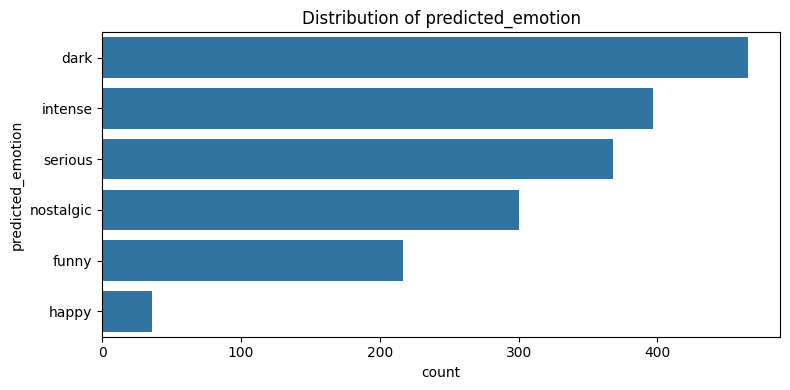

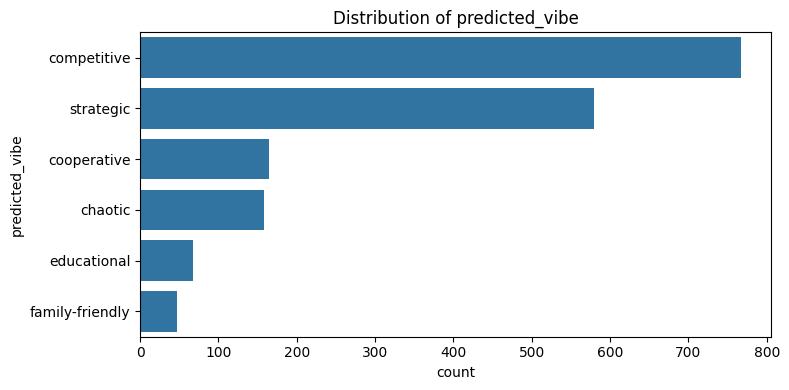

In [ ]:
for col in ["predicted_emotion", "predicted_vibe"]:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, y=col, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

## Task 2: Machine Learning

### Task 2.1: Regression to predict the rating

In [ ]:
df = pd.read_csv("boardgames_3000_with_dual_tone.csv", sep=";")
df.head()

,id,name,description,year,rating,complexity,minplayers,maxplayers,playingtime,minage,categories,clean_description,light_description,predicted_emotion,predicted_vibe
0,1,Die Macher,Die Macher is a game about seven sequential po...,1986,7.58777,4.3081,3,5,240,14,"Economic, Negotiation, Political",die macher game seven sequential political rac...,Die Macher is a game about seven sequential po...,nostalgic,competitive
1,2,Dragonmaster,Dragonmaster is a trick-taking card game based...,1981,6.66468,1.9643,3,4,30,12,"Card Game, Fantasy",dragonmaster trick taking card game base old g...,Dragonmaster is a trick-taking card game based...,nostalgic,competitive
2,3,Samurai,Samurai is set in medieval Japan. Players comp...,1998,7.47596,2.4420,2,4,60,10,"Abstract Strategy, Medieval",samurai set medieval japan player compete gain...,Samurai is set in medieval Japan. Players comp...,intense,competitive
3,4,Tal der Könige,When you see the triangular box and the luxuri...,1992,6.61540,2.6875,2,4,60,12,Ancient,triangular box luxurious large block tal der k...,When you see the triangular box and the luxuri...,nostalgic,competitive
4,5,Acquire,"In Acquire, each player strategically invests ...",1964,7.35053,2.4923,2,6,90,12,"Economic, Territory Building",acquire player strategically invest business t...,"In Acquire, each player strategically invests ...",dark,strategic


In [ ]:
# Set target variable
y = df["complexity"].values

# GloVe embeddings matrix
def load_glove_embeddings(filepath="glove.6B.100d.txt"):
    embeddings = {}
    with open(filepath, "r", encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove = load_glove_embeddings("glove.6B.100d.txt")

def get_glove_vector(text, glove, dim=100):
    words = text.split()
    vectors = [glove[word] for word in words if word in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

df["glove_vector"] = df["clean_description"].apply(lambda x: get_glove_vector(x, glove))

X_glove = np.vstack(df["glove_vector"])

# Metadata features
X_meta = df[["rating", "year", "minplayers", "maxplayers", "playingtime", "minage"]].values

# One-hot encode for emotion + vibe
encoder = OneHotEncoder(drop="first", sparse_output=False)
X_tone = encoder.fit_transform(df[["predicted_emotion", "predicted_vibe"]])

In [ ]:
# Feature names for future interpretation
glove_feat = [f"glove_{i}" for i in range(X_glove.shape[1])]
meta_feat = ["rating", "year", "minplayers", "maxplayers", "playingtime", "minage"]
tone_feat = list(encoder.get_feature_names_out(["predicted_emotion", "predicted_vibe"]))
all_feat_names = glove_feat + meta_feat + tone_feat

In [ ]:
# Helper functions
def train_and_evaluate(X, y, model_name="Model", regressor=None):
    if regressor is None:
        regressor = RandomForestRegressor(random_state=42)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model_name} - Test RMSE: {rmse:.4f}")
    plot_pred_vs_actual(y_test, y_pred, title=model_name)
    return regressor, mse, rmse

def plot_pred_vs_actual(y_true, y_pred, title="Prediction Plot"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    sns.lineplot(x=[y_true.min(), y_true.max()], y=[y_true.min(), y_true.max()], color='red', linestyle="--")
    plt.xlabel("Actual Rating")
    plt.ylabel("Predicted Rating")
    plt.title(f"{title}: Predicted vs Actual")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_importances(model, feature_names, top_n=20):
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
    plt.title("Top Feature Importances")
    plt.tight_layout()
    plt.show()

#### Performance without feature extraction/selection algorithms

ONLY METADATA

Metadata Only - Test RMSE: 0.8610


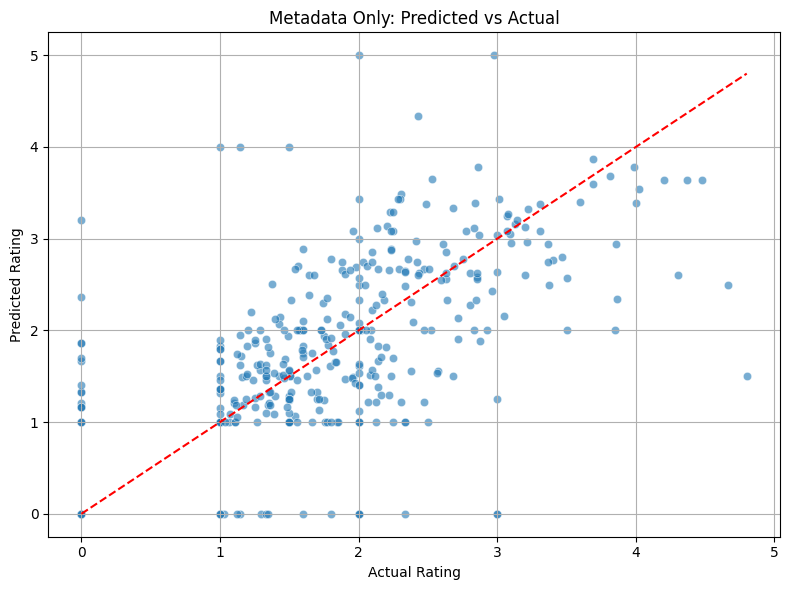

In [ ]:
X_meta_full = np.hstack([X_meta, X_tone])
model_meta = train_and_evaluate(X_meta, y, model_name="Metadata Only", regressor=DecisionTreeRegressor(random_state=42))

METADATA + TF-IDF

In [ ]:
X_tfidf_meta = np.hstack([X_tfidf_gensim, X_meta, X_tone])
model_tfidf_meta = train_and_evaluate(X_tfidf_meta, y, model_name="TF-IDF + Metadata")

NameError: name 'X_tfidf_gensim' is not defined

METADATA + GLOVE

Metadata + GloVe - Test RMSE: 0.5879


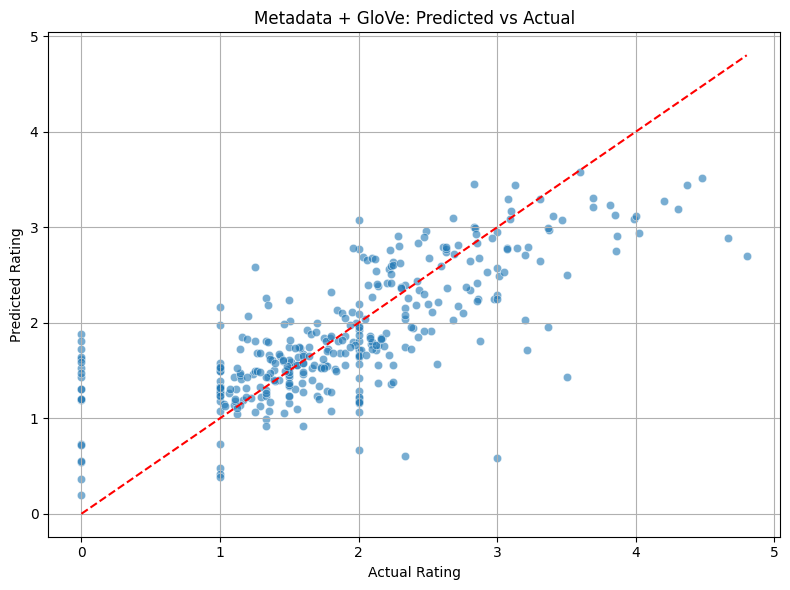

In [ ]:
X_glove_meta = np.hstack([X_glove, X_meta, X_tone])
model_glove_meta = train_and_evaluate(X_glove_meta, y, model_name="Metadata + GloVe")

METADATA + DOC2VEC

Doc2Vec + Metadata - Test RMSE: 0.5939


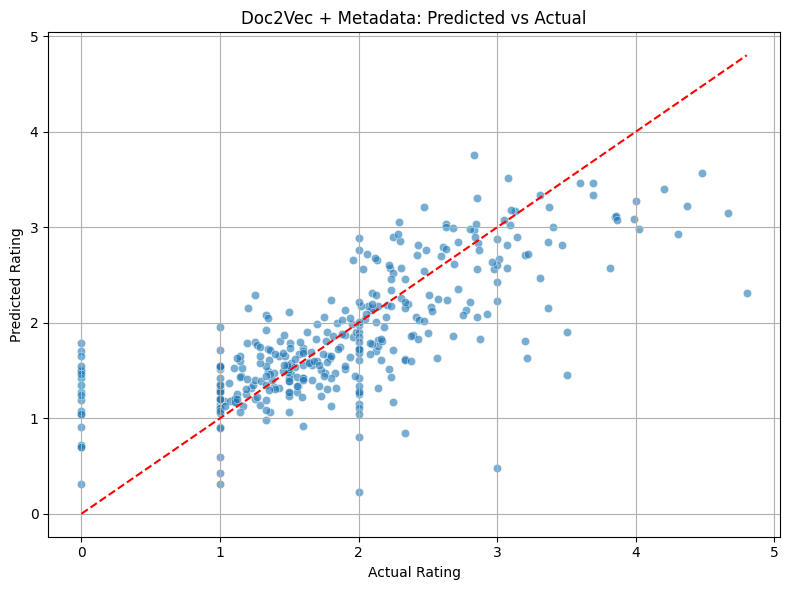

In [ ]:
X_doc2vec_meta = np.hstack([X_doc2vec, X_meta, X_tone])
model_doc2vec_meta = train_and_evaluate(X_doc2vec_meta, y, model_name="Doc2Vec + Metadata")

METADATA + LDA

LDA + Metadata - Test RMSE: 0.5987


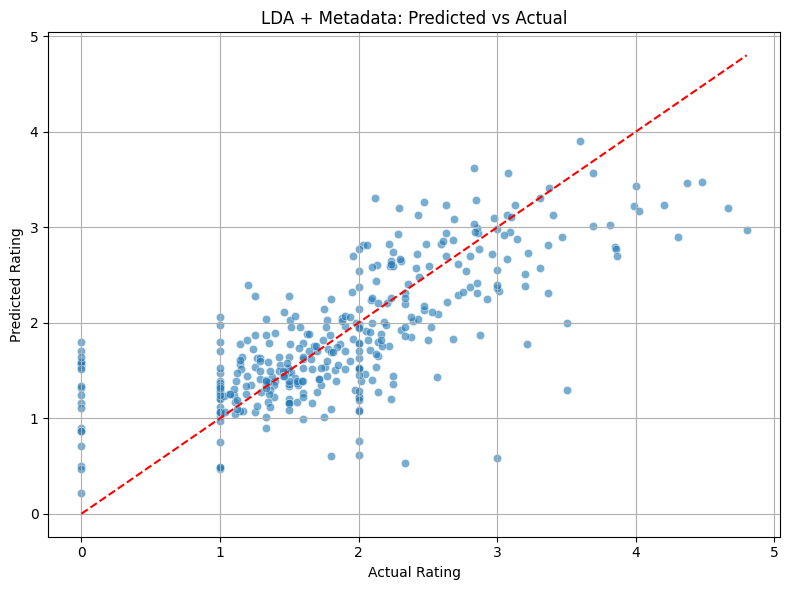

In [ ]:
X_lda_meta = np.hstack([theta_matrix, X_meta, X_tone])
model_lda_meta = train_and_evaluate(X_lda_meta, y, model_name="LDA + Metadata")

In [ ]:
rmse_results = {
    "Metadata Only": model_meta,
    "TF-IDF + Metadata": model_tfidf_meta,
    "GloVe + Metadata": model_glove_meta,
    "Doc2Vec + Metadata": model_doc2vec_meta,
    "LDA + Metadata": model_lda_meta
}

for name, (model, mse, rmse) in rmse_results.items():
    print(f"{name}: RMSE = {rmse:.4f}")

Metadata Only: RMSE = 0.8610
TF-IDF + Metadata: RMSE = 0.5967
GloVe + Metadata: RMSE = 0.5904
Doc2Vec + Metadata: RMSE = 0.5939
LDA + Metadata: RMSE = 0.5987


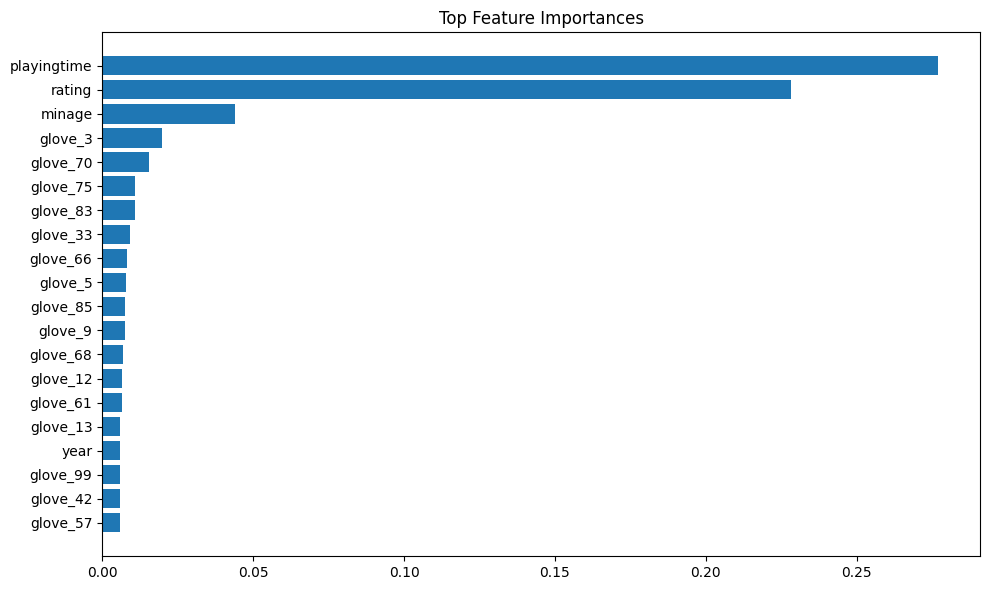

In [ ]:
plot_feature_importances(model_glove_meta[0], all_feat_names)

#### Miguel: Trying predicting based on complexity

##### Complexity 1: Regression Tree

In [ ]:
df

,id,name,description,year,rating,complexity,minplayers,maxplayers,playingtime,minage,categories,clean_description,light_description,predicted_emotion,predicted_vibe,glove_vector
0,1,Die Macher,Die Macher is a game about seven sequential po...,1986,7.58777,4.3081,3,5,240,14,"Economic, Negotiation, Political",die macher game seven sequential political rac...,Die Macher is a game about seven sequential po...,nostalgic,competitive,"[-0.2647349, 0.22358689, 0.37586272, -0.132556..."
1,2,Dragonmaster,Dragonmaster is a trick-taking card game based...,1981,6.66468,1.9643,3,4,30,12,"Card Game, Fantasy",dragonmaster trick taking card game base old g...,Dragonmaster is a trick-taking card game based...,nostalgic,competitive,"[-0.08550092, 0.17018886, 0.32481802, -0.30027..."
2,3,Samurai,Samurai is set in medieval Japan. Players comp...,1998,7.47596,2.4420,2,4,60,10,"Abstract Strategy, Medieval",samurai set medieval japan player compete gain...,Samurai is set in medieval Japan. Players comp...,intense,competitive,"[-0.14252852, 0.30184495, 0.19210964, -0.02005..."
3,4,Tal der Könige,When you see the triangular box and the luxuri...,1992,6.61540,2.6875,2,4,60,12,Ancient,triangular box luxurious large block tal der k...,When you see the triangular box and the luxuri...,nostalgic,competitive,"[-0.090712585, 0.21279587, 0.094686866, 0.0159..."
4,5,Acquire,"In Acquire, each player strategically invests ...",1964,7.35053,2.4923,2,6,90,12,"Economic, Territory Building",acquire player strategically invest business t...,"In Acquire, each player strategically invests ...",dark,strategic,"[-0.07029529, 0.19396575, 0.1906798, -0.116000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,2992,Rythmo,2-player abstract based on a medieval game cal...,1985,5.50000,3.5000,2,2,30,0,"Abstract Strategy, Math, Number",player abstract base medieval game call rithmo...,2-player abstract based on a medieval game cal...,funny,strategic,"[-0.27730125, 0.34989828, 0.1149894, 0.1405766..."
1779,2994,Guderian's Blitzkrieg: The Drive on Moscow,"Guderian's Blitzkrieg - The Drive on Moscow, S...",1992,7.03520,3.8667,2,2,360,12,"Wargame, World War II",guderian blitzkrieg drive moscow september dec...,"Guderian's Blitzkrieg - The Drive on Moscow, S...",intense,strategic,"[-0.2265046, 0.1380127, 0.2633096, -0.06554289..."
1780,2996,Dodge City,Directly from the rules:&#10;&#10;The board sh...,1983,5.57179,2.3333,2,5,60,8,American West,directly rule board show western town dodge ci...,Directly from the rules:\n\nThe board shows th...,serious,competitive,"[0.03376208, 0.18295278, 0.32932884, -0.114422..."
1781,2998,Reds! The Russian Civil War 1918-1921,Reds! The Russian Civil War 1918-1921 is a two...,2001,7.29145,3.0789,1,2,360,12,"Civil War, Wargame",red russian civil war player wargame cover dra...,Reds! The Russian Civil War 1918-1921 is a two...,intense,chaotic,"[-0.20963709, 0.17870425, 0.09118565, 0.023731..."


In [ ]:
print(df['complexity'].min())
print(df['complexity'].max())


0.0
5.0


In [ ]:
# Round complexity to the nearest integer and count occurrences
complexity_counts = df['complexity'].round().value_counts().sort_index()

print(complexity_counts)


complexity
0.0    110
1.0    508
2.0    788
3.0    313
4.0     58
5.0      6
Name: count, dtype: int64


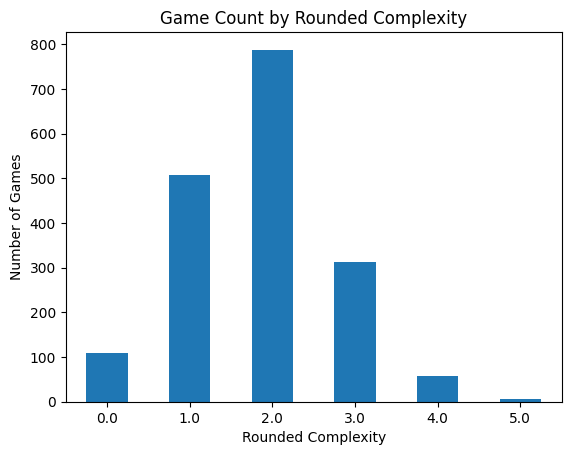

In [ ]:
complexity_counts.plot(kind='bar')
plt.xlabel('Rounded Complexity')
plt.ylabel('Number of Games')
plt.title('Game Count by Rounded Complexity')
plt.xticks(rotation=0)
plt.show()


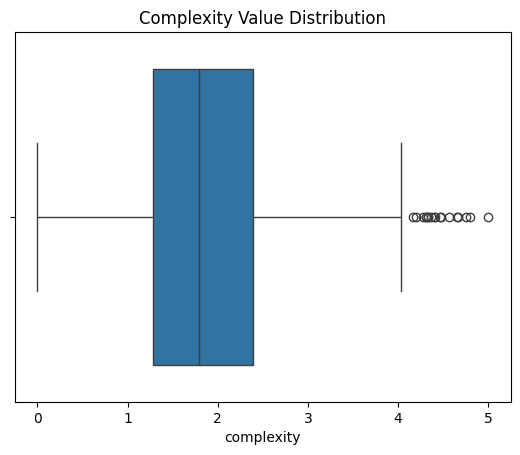

In [ ]:
# Visualize the distribution of complexity values
sns.boxplot(x=df['complexity'])
plt.title('Complexity Value Distribution')
plt.show()


In [ ]:
# 1. Select structured features
structured_cols = ['playingtime', 'rating', 'minplayers', 'maxplayers', 'minage', 'year']
X_structured = df[structured_cols].fillna(0).values

# 2. Extract GloVe embeddings
X_text = np.vstack(df['glove_vector'].values)

# 3. Combine structured and text features
X_combined = np.hstack((X_structured, X_text))
y = df['complexity'].values


X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


In [ ]:

# Initialize the model with 100 trees
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate R² Score and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")


R² Score: 0.5644
Mean Squared Error: 0.3443


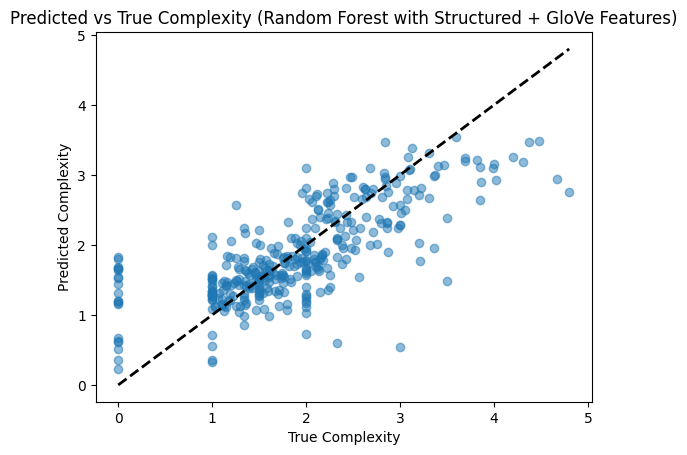

In [ ]:

# Plot predictions vs. true values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel("True Complexity")
plt.ylabel("Predicted Complexity")
plt.title("Predicted vs True Complexity (Random Forest with Structured + GloVe Features)")
plt.show()


##### Complexity 2: Simple MLP with just description

In [ ]:

# 1. Extract the GloVe embeddings (text feature) and complexity (target)
X_text = np.vstack(df['glove_vector'].values)
y = df['complexity'].values

# 2. Split into train/test
X_txt_train, X_txt_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42
)

# 3. Create a PyTorch Dataset
class BoardGameTextDataset(Dataset):
    def __init__(self, X_text, y):
        self.X_text = torch.tensor(X_text, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # output should be shape (N, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_text[idx], self.y[idx]

# 4. Create Dataloaders
train_dataset = BoardGameTextDataset(X_txt_train, y_train)
test_dataset = BoardGameTextDataset(X_txt_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
import torch.nn as nn

class GameComplexityRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        # MLP Architecture
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 128),  # Input layer (input_dim = size of glove_vector)
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(128, 64),  # Hidden layer
            nn.ReLU(),
            nn.Linear(64, 1)  # Output layer (predicting complexity)
        )

    def forward(self, x):
        return self.mlp(x)

# Instantiate the model
input_dim = X_txt_train.shape[1]  # The size of the GloVe vector (e.g., 100, 300, etc.)
model = GameComplexityRegressor(input_dim)


In [ ]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
# Training Loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Forward pass
        predictions = model(X_batch)  # Predictions from the model
        loss = criterion(predictions, y_batch)  # Compute loss

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model weights

        running_loss += loss.item() * X_batch.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")


Epoch [1/20], Loss: 1.6074
Epoch [2/20], Loss: 0.6117
Epoch [3/20], Loss: 0.5452
Epoch [4/20], Loss: 0.5084
Epoch [5/20], Loss: 0.5268
Epoch [6/20], Loss: 0.5115
Epoch [7/20], Loss: 0.4947
Epoch [8/20], Loss: 0.4990
Epoch [9/20], Loss: 0.4906
Epoch [10/20], Loss: 0.4792
Epoch [11/20], Loss: 0.4889
Epoch [12/20], Loss: 0.4819
Epoch [13/20], Loss: 0.4738
Epoch [14/20], Loss: 0.4728
Epoch [15/20], Loss: 0.4538
Epoch [16/20], Loss: 0.4581
Epoch [17/20], Loss: 0.4471
Epoch [18/20], Loss: 0.4505
Epoch [19/20], Loss: 0.4487
Epoch [20/20], Loss: 0.4328


R² Score: 0.3569
Mean Squared Error: 0.5083


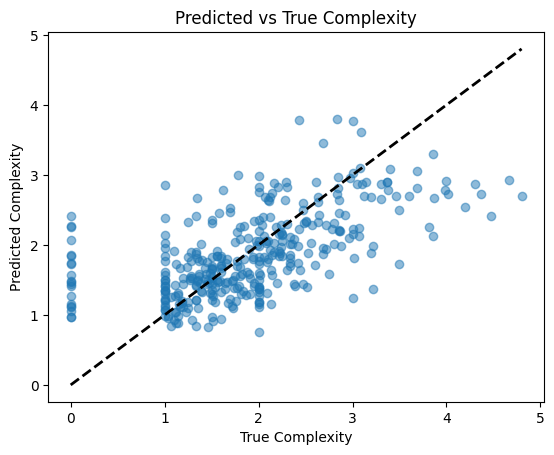

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate on the test set
model.eval()  # Set the model to evaluation mode
y_pred = []
y_true = []

with torch.no_grad():  # No need to compute gradients during evaluation
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        y_pred.append(predictions.numpy())
        y_true.append(y_batch.numpy())

# Flatten the predictions and true values
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

# Calculate R² Score and MSE
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

# Plot predictions vs. true values
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=2)
plt.xlabel("True Complexity")
plt.ylabel("Predicted Complexity")
plt.title("Predicted vs True Complexity")
plt.show()


##### Complexity 3: Simple MLP with description + features

In [ ]:
# 1. Select numerical and glove features
structured_cols = ['playingtime', 'rating', 'minplayers', 'maxplayers', 'minage', 'year']
X_structured = df[structured_cols].fillna(0).values
X_text = np.vstack(df['glove_vector'].values)
y = df['complexity'].values

# 2. Normalize structured features
scaler = StandardScaler()
X_structured = scaler.fit_transform(X_structured)

# 3. Combine into a PyTorch Dataset
class BoardGameDataset(Dataset):
    def __init__(self, X_structured, X_text, y):
        self.X_structured = torch.tensor(X_structured, dtype=torch.float32)
        self.X_text = torch.tensor(X_text, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # output should be shape (N, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_structured[idx], self.X_text[idx], self.y[idx]

# 4. Train/test/validation split
X_str_train, X_str_temp, X_txt_train, X_txt_temp, y_train, y_temp = train_test_split(
    X_structured, X_text, y, test_size=0.2, random_state=42
)
X_str_val, X_str_test, X_txt_val, X_txt_test, y_val, y_test = train_test_split(
    X_str_temp, X_txt_temp, y_temp, test_size=0.5, random_state=42
)

# 5. Dataloaders
train_dataset = BoardGameDataset(X_str_train, X_txt_train, y_train)
val_dataset = BoardGameDataset(X_str_val, X_txt_val, y_val)
test_dataset = BoardGameDataset(X_str_test, X_txt_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)



In [ ]:
import torch.nn as nn

class GameComplexityRegressor(nn.Module):
    def __init__(self, struct_dim, text_dim):
        super().__init__()

        # Text branch (for GloVe vector)
        self.text_net = nn.Sequential(
            nn.Linear(text_dim, 256),    # Increased layer size
            nn.ReLU(),
            nn.Dropout(0.3),             # Regularization via dropout
            nn.Linear(256, 128),         # Added a second layer
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Structured branch
        self.struct_net = nn.Sequential(
            nn.Linear(struct_dim, 128),  # Increased layer size
            nn.ReLU(),
            nn.Dropout(0.3),             # Added dropout for regularization
            nn.Linear(128, 64),          # Added a second layer
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Combined
        self.combined_net = nn.Sequential(
            nn.Linear(128 + 64, 128),    # Adjusted input size based on the previous layers
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Output: complexity (a float)
        )

    def forward(self, struct_input, text_input):
        struct_out = self.struct_net(struct_input)
        text_out = self.text_net(text_input)
        combined = torch.cat([struct_out, text_out], dim=1)
        return self.combined_net(combined)


In [ ]:
pip install torchinfo

In [ ]:
from torchinfo import summary

# Example input dimensions
struct_dim = len(structured_cols)     # e.g., 6 features
text_dim = len(df['glove_vector'].iloc[0])  # e.g., 300 for GloVe

# Instantiate the model
model = GameComplexityRegressor(struct_dim=struct_dim, text_dim=text_dim)

# Move to device if you're using GPU (optional)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Create dummy inputs to simulate a batch of data
dummy_struct = torch.zeros((32, struct_dim)).to(device)  # batch of 32
dummy_text = torch.zeros((32, text_dim)).to(device)

# Show the model summary
summary(model, input_data=(dummy_struct, dummy_text))


Layer (type:depth-idx)                   Output Shape              Param #
GameComplexityRegressor                  [32, 1]                   --
├─Sequential: 1-1                        [32, 64]                  --
│    └─Linear: 2-1                       [32, 128]                 896
│    └─ReLU: 2-2                         [32, 128]                 --
│    └─Dropout: 2-3                      [32, 128]                 --
│    └─Linear: 2-4                       [32, 64]                  8,256
│    └─ReLU: 2-5                         [32, 64]                  --
│    └─Dropout: 2-6                      [32, 64]                  --
├─Sequential: 1-2                        [32, 128]                 --
│    └─Linear: 2-7                       [32, 256]                 25,856
│    └─ReLU: 2-8                         [32, 256]                 --
│    └─Dropout: 2-9                      [32, 256]                 --
│    └─Linear: 2-10                      [32, 128]                 32,896
│  

In [ ]:
import torch.optim as optim


model = GameComplexityRegressor(struct_dim, text_dim).to(device)


criterion = nn.MSELoss()


optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0
best_model_state = None
epochs = 40
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for struct_batch, text_batch, target in train_loader:
        struct_batch = struct_batch.to(device)
        text_batch = text_batch.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        outputs = model(struct_batch, text_batch)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * struct_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for struct_batch, text_batch, target in val_loader:
            struct_batch = struct_batch.to(device)
            text_batch = text_batch.to(device)
            target = target.to(device)

            outputs = model(struct_batch, text_batch)
            loss = criterion(outputs, target)
            val_loss += loss.item() * struct_batch.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


Epoch 1/40 - Train Loss: 1.3784 - Val Loss: 0.4057
Epoch 2/40 - Train Loss: 0.4310 - Val Loss: 0.3117
Epoch 3/40 - Train Loss: 0.3682 - Val Loss: 0.3028
Epoch 4/40 - Train Loss: 0.3737 - Val Loss: 0.3647
Epoch 5/40 - Train Loss: 0.3718 - Val Loss: 0.3297
Epoch 6/40 - Train Loss: 0.3614 - Val Loss: 0.2810
Epoch 7/40 - Train Loss: 0.3441 - Val Loss: 0.2977
Epoch 8/40 - Train Loss: 0.3477 - Val Loss: 0.2783
Epoch 9/40 - Train Loss: 0.3437 - Val Loss: 0.2919
Epoch 10/40 - Train Loss: 0.3375 - Val Loss: 0.2747
Epoch 11/40 - Train Loss: 0.3227 - Val Loss: 0.2711
Epoch 12/40 - Train Loss: 0.3227 - Val Loss: 0.2733
Epoch 13/40 - Train Loss: 0.3089 - Val Loss: 0.2767
Epoch 14/40 - Train Loss: 0.3027 - Val Loss: 0.2870
Epoch 15/40 - Train Loss: 0.3116 - Val Loss: 0.2697
Epoch 16/40 - Train Loss: 0.3060 - Val Loss: 0.2793
Epoch 17/40 - Train Loss: 0.2961 - Val Loss: 0.2813
Epoch 18/40 - Train Loss: 0.2896 - Val Loss: 0.2891
Epoch 19/40 - Train Loss: 0.2856 - Val Loss: 0.2694
Epoch 20/40 - Train L

In [ ]:
model.eval()
test_loss = 0.0

with torch.no_grad():  # no gradients needed during eval
    for struct_batch, text_batch, target in test_loader:
        struct_batch = struct_batch.to(device)
        text_batch = text_batch.to(device)
        target = target.to(device)

        outputs = model(struct_batch, text_batch)
        loss = criterion(outputs, target)
        test_loss += loss.item() * struct_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss (MSE): {test_loss:.4f}")


Test Loss (MSE): 0.4362


In [ ]:
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()

# Variables to store the true and predicted values
true_values = []
predictions = []

# No gradients needed during evaluation
with torch.no_grad():
    for struct_batch, text_batch, target in val_loader:
        struct_batch = struct_batch.to(device)
        text_batch = text_batch.to(device)
        target = target.to(device)

        # Forward pass
        outputs = model(struct_batch, text_batch)

        # Store the true and predicted values
        true_values.extend(target.cpu().numpy())
        predictions.extend(outputs.cpu().numpy())

# Convert lists to numpy arrays
true_values = np.array(true_values)
predictions = np.array(predictions)

# Calculate MSE on validation set (optional)
from sklearn.metrics import mean_squared_error
val_mse = mean_squared_error(true_values, predictions)
print(f"Validation MSE: {val_mse:.4f}")


Validation MSE: 0.3041


In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(true_values, predictions)
print(f"R² Score: {r2:.4f}")


R² Score: 0.5578


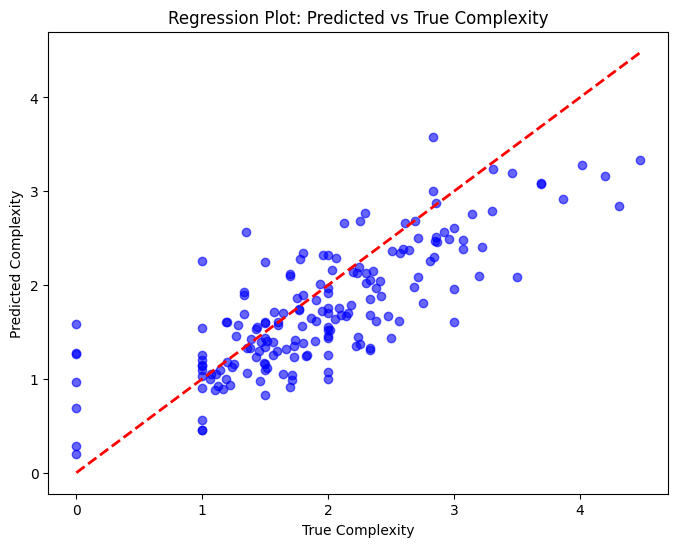

In [ ]:
# Plot true values vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(true_values, predictions, alpha=0.6, color='blue')
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='red', linestyle='--', linewidth=2)
plt.xlabel("True Complexity")
plt.ylabel("Predicted Complexity")
plt.title("Regression Plot: Predicted vs True Complexity")
plt.show()


In [ ]:
# First, set the device to 'cuda' if available, otherwise use 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the selected device (GPU or CPU)
model.to(device)

# Convert the input data into PyTorch tensors and move them to the same device
X_str_test_tensor = torch.tensor(X_str_test, dtype=torch.float32).to(device)
X_txt_test_tensor = torch.tensor(X_txt_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

def permutation_importance(model, X_structured, X_text, y, metric_fn=mean_squared_error):
    model.eval()  # Set the model to evaluation mode
    baseline = model(X_structured, X_text)
    baseline_score = metric_fn(baseline.detach().cpu().numpy(), y.detach().cpu().numpy())

    importances = []

    for idx in range(X_structured.shape[1]):
        X_structured_perm = X_structured.clone()
        X_structured_perm[:, idx] = torch.rand_like(X_structured_perm[:, idx])  # Randomize this feature

        permuted_pred = model(X_structured_perm, X_text)
        permuted_score = metric_fn(permuted_pred.detach().cpu().numpy(), y.detach().cpu().numpy())

        # Importance is the performance drop when permuting the feature
        importances.append(baseline_score - permuted_score)

    return importances

# Example of calculating feature importance
importance_scores = permutation_importance(model, X_str_test_tensor, X_txt_test_tensor, y_test_tensor)
print("Permutation Importance:", importance_scores)


Permutation Importance: [0.0014114975929260254, -0.06190970540046692, -0.008895337581634521, -0.012304633855819702, -0.004093676805496216, 0.0007227957248687744]


#### Old version

Just with metadata complexity and year

In [ ]:

# Select only the 'complexity' and 'year' columns
X_metadata = df[["complexity", "year"]].values

# Target variable y
y = df["rating"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_metadata, y, test_size=0.2, random_state=42)

# Train a DecisionTree Regressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and calculate MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

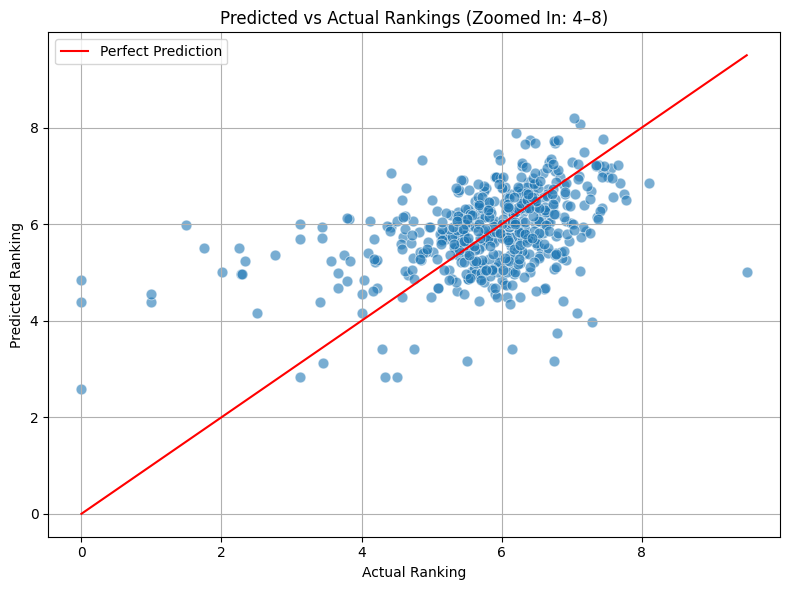

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=60)
sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Ranking")
plt.ylabel("Predicted Ranking")
plt.title("Predicted vs Actual Rankings (Zoomed In: 4–8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Just with description embedded

In [ ]:
import pandas as pd
import numpy as np
import re
import html
import spacy
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Load GloVe embeddings
def load_glove_embeddings(filepath="glove.6B.100d.txt"):
    embeddings = {}
    with open(filepath, "r", encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Convert a description to a GloVe vector
def get_glove_vector(text, glove, dim=100):
    words = text.split()
    vectors = [glove[word] for word in words if word in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)


glove = load_glove_embeddings("glove.6B.100d.txt")


df["glove_vector"] = df["clean_description"].apply(lambda x: get_glove_vector(x, glove))

# Stack into matrix
X = np.vstack(df["glove_vector"].values)
y = df["rating"]  # Change this to your target column

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train regressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")


KeyboardInterrupt: 

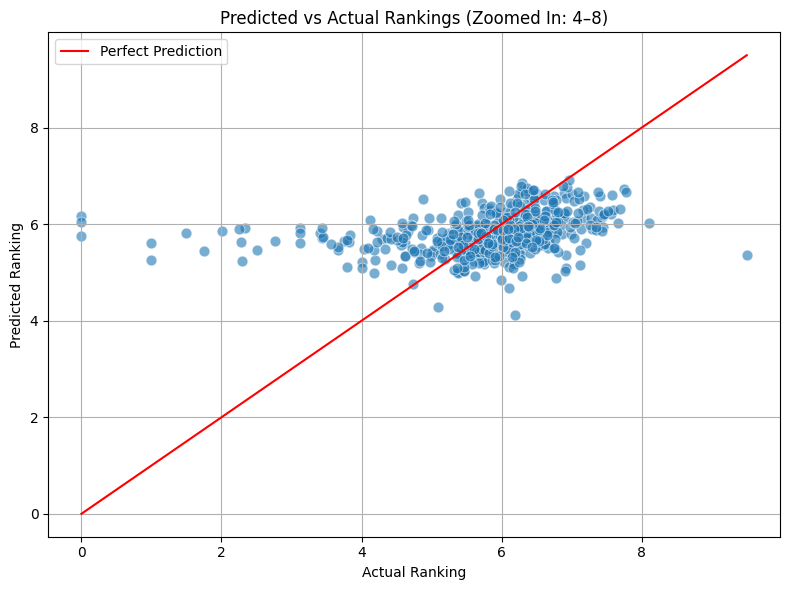

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=60)
sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Ranking")
plt.ylabel("Predicted Ranking")
plt.title("Predicted vs Actual Rankings (Zoomed In: 4–8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Now we use the other metadata complexity and year

In [ ]:
X_text = np.vstack(df["glove_vector"].values)
X_metadata = df[["complexity", "year"]].values
X = np.hstack([X_text, X_metadata])


y = df["rating"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest Regressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and calculate MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")


Test MSE: 0.9093


It actually improves with the combination of the two

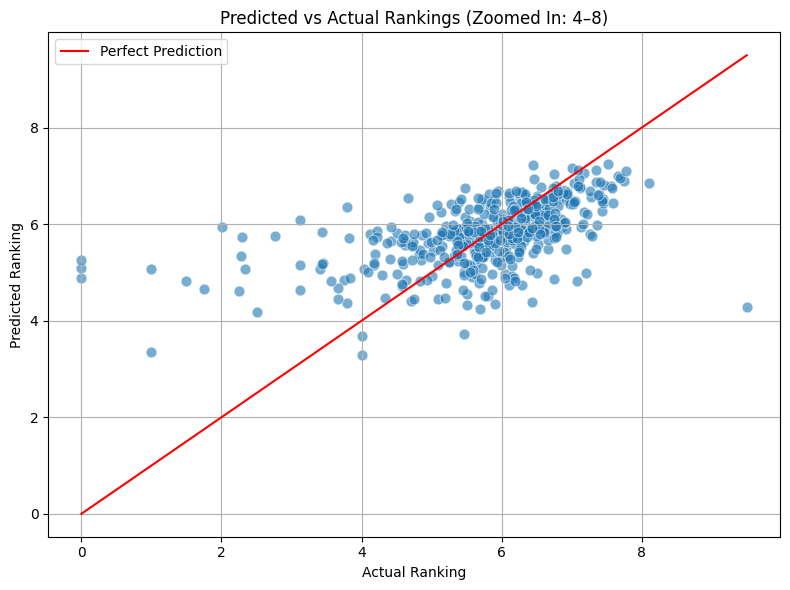

In [ ]:
# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=60)
sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Ranking")
plt.ylabel("Predicted Ranking")
plt.title("Predicted vs Actual Rankings (Zoomed In: 4–8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Now let's try with the tone predicted

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Create feature matrix X (including 'complexity', 'year' and 'predicted_tone' along with GloVe vectors)
X_text = np.vstack(df["glove_vector"].values)
X_metadata = df[["complexity", "year"]].values

# One-hot encode 'predicted_tone' if it's categorical
encoder = OneHotEncoder(drop='first')  # Drop first category to avoid multicollinearity
predicted_tone_encoded = encoder.fit_transform(df[["predicted_tone"]]).toarray()

# Combine all features
X = np.hstack([X_text, X_metadata, predicted_tone_encoded])

# Target variable y
y = df["rating"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest Regressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and calculate MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")



Test MSE: 0.8936


It doesn't really improve much

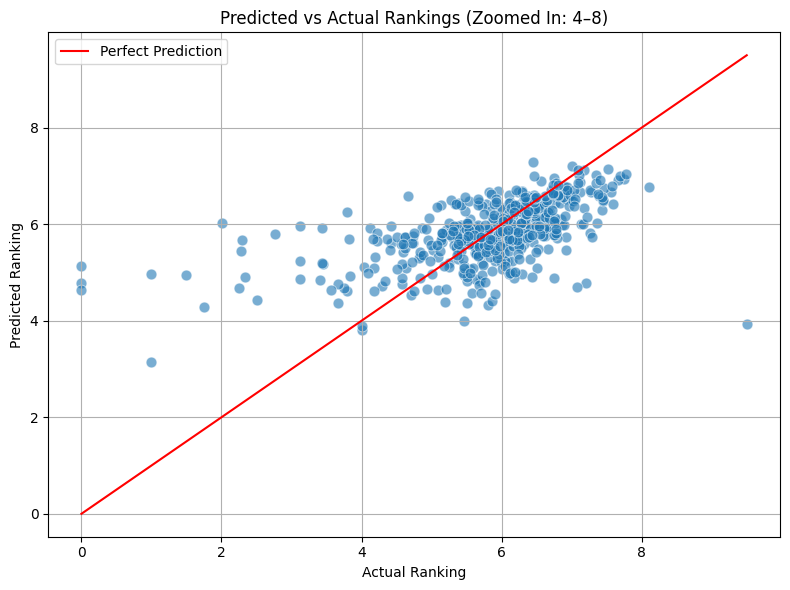

In [ ]:
# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=60)
sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Ranking")
plt.ylabel("Predicted Ranking")
plt.title("Predicted vs Actual Rankings (Zoomed In: 4–8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Task 2.1: Classification

### Task 2.1: Recommender system

#### Load dataset and reviews

In [2]:
filename = "datasets/boardgames_3000_with_dual_tone.csv"
games = pd.read_csv(filename, sep=";")
games

,id,name,description,year,rating,complexity,minplayers,maxplayers,playingtime,minage,categories,clean_description,light_description,predicted_emotion,predicted_vibe
0,1,Die Macher,Die Macher is a game about seven sequential po...,1986,7.58777,4.3081,3,5,240,14,"Economic, Negotiation, Political",die macher game seven sequential political rac...,Die Macher is a game about seven sequential po...,nostalgic,competitive
1,2,Dragonmaster,Dragonmaster is a trick-taking card game based...,1981,6.66468,1.9643,3,4,30,12,"Card Game, Fantasy",dragonmaster trick taking card game base old g...,Dragonmaster is a trick-taking card game based...,nostalgic,competitive
2,3,Samurai,Samurai is set in medieval Japan. Players comp...,1998,7.47596,2.4420,2,4,60,10,"Abstract Strategy, Medieval",samurai set medieval japan player compete gain...,Samurai is set in medieval Japan. Players comp...,intense,competitive
3,4,Tal der Könige,When you see the triangular box and the luxuri...,1992,6.61540,2.6875,2,4,60,12,Ancient,triangular box luxurious large block tal der k...,When you see the triangular box and the luxuri...,nostalgic,competitive
4,5,Acquire,"In Acquire, each player strategically invests ...",1964,7.35053,2.4923,2,6,90,12,"Economic, Territory Building",acquire player strategically invest business t...,"In Acquire, each player strategically invests ...",dark,strategic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,2992,Rythmo,2-player abstract based on a medieval game cal...,1985,5.50000,3.5000,2,2,30,0,"Abstract Strategy, Math, Number",player abstract base medieval game call rithmo...,2-player abstract based on a medieval game cal...,funny,strategic
1779,2994,Guderian's Blitzkrieg: The Drive on Moscow,"Guderian's Blitzkrieg - The Drive on Moscow, S...",1992,7.03520,3.8667,2,2,360,12,"Wargame, World War II",guderian blitzkrieg drive moscow september dec...,"Guderian's Blitzkrieg - The Drive on Moscow, S...",intense,strategic
1780,2996,Dodge City,Directly from the rules:&#10;&#10;The board sh...,1983,5.57179,2.3333,2,5,60,8,American West,directly rule board show western town dodge ci...,Directly from the rules:\n\nThe board shows th...,serious,competitive
1781,2998,Reds! The Russian Civil War 1918-1921,Reds! The Russian Civil War 1918-1921 is a two...,2001,7.29145,3.0789,1,2,360,12,"Civil War, Wargame",red russian civil war player wargame cover dra...,Reds! The Russian Civil War 1918-1921 is a two...,intense,chaotic


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
filename = "bgg-26m-reviews.csv"
reviews = pd.read_csv(filename, sep=",")
reviews

,Unnamed: 0,user,rating,comment,ID,name
0,0,sidehacker,10.0,NaN,13,CATAN
1,1,Varthlokkur,10.0,NaN,13,CATAN
2,2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,CATAN
3,3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,CATAN
4,4,ssmooth,10.0,NaN,13,CATAN
...,...,...,...,...,...,...
26200007,26200007,VetruvianGamer,3.0,*,205769,ButterKO
26200008,26200008,jenny70,3.0,If I've played correctly... I think it's broke...,205769,ButterKO
26200009,26200009,elinboyan,3.0,NaN,205769,ButterKO
26200010,26200010,himokl,3.0,NaN,205769,ButterKO


#### Dataset exploration

In [4]:
# Unique game names in the reviews
unique_names = reviews["name"].unique()
print(len(unique_names))

27346


In [5]:
# Unique reviews of games in the reviews
reviewed_ids = reviews["ID"].unique()

In [6]:
# Find games with and without reviews
games_with_reviews = games[games["id"].isin(reviewed_ids)]
games_without_reviews = games[~games["id"].isin(reviewed_ids)]

In [7]:
print(f"Total games: {len(games)}")
print(f"Games with reviews: {len(games_with_reviews)}")
print(f"Games without reviews: {len(games_without_reviews)}")

Total games: 1783
Games with reviews: 1390
Games without reviews: 393


#### Filtering the reviews to reduce the number of entries

In [8]:
# Keep only reviews for games that exist in the games dataset
valid_game_ids = set(games["id"].unique())
filtered_reviews = reviews[reviews["ID"].isin(valid_game_ids)].copy()
filtered_reviews

,Unnamed: 0,user,rating,comment,ID,name
0,0,sidehacker,10.0,NaN,13,CATAN
1,1,Varthlokkur,10.0,NaN,13,CATAN
2,2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,CATAN
3,3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,CATAN
4,4,ssmooth,10.0,NaN,13,CATAN
...,...,...,...,...,...,...
26199316,26199316,Pyrogal,1.0,Total garbage. This game looks like it was a ...,1546,Worlds of Heroes & Tyrants
26199317,26199317,jbuergel,1.0,This might be the biggest ripoff I've ever bee...,1546,Worlds of Heroes & Tyrants
26199318,26199318,feztacular1,1.0,This game is a turd. Pure and simple.,1546,Worlds of Heroes & Tyrants
26199319,26199319,balsak40,1.0,"Awful, just awful.",1546,Worlds of Heroes & Tyrants


In [9]:
# Check the number of reviews per game
review_counts = reviews["ID"].value_counts()
review_counts.describe()

count     27865.000000
mean        940.248053
std        4192.676666
min          29.000000
25%          56.000000
50%         125.000000
75%         407.000000
max      131303.000000
Name: count, dtype: float64

In [10]:
# Shuffle reviews to ensure randomness
reviews_shuffled = reviews.sample(frac=1, random_state=42)

In [11]:
# Limit maximum number of reviews per game
max_reviews_per_game = 200
capped_reviews = reviews_shuffled.groupby("ID").head(max_reviews_per_game).reset_index(drop=True)

In [12]:
capped_reviews["ID"].value_counts().max(), capped_reviews.shape

(200, (3525577, 6))

In [13]:
# Limit maximum number of reviews per user
max_reviews_per_user = 500
balanced_reviews = capped_reviews.groupby("user").head(max_reviews_per_user).reset_index(drop=True)

In [14]:
# Should be <= 500
balanced_reviews["user"].value_counts().max(), balanced_reviews.shape

(500, (3433086, 6))

#### Content-based system

In [ ]:
#filtered_reviews.to_csv("filtered_reviews.csv", sep=";", index=False)

In [ ]:
reviews = filtered_reviews

In [16]:
valid_game_ids = set(games["id"].unique())
filtered_reviews = reviews[reviews["ID"].isin(valid_game_ids)].copy()

In [17]:
def load_glove_embeddings(filepath="glove.6B.100d.txt"):
    embeddings = {}
    with open(filepath, "r", encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

def get_glove_vector(text, glove, dim=100):
    words = text.split()
    vectors = [glove[word] for word in words if word in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

In [18]:
glove = load_glove_embeddings("glove.6B.100d.txt")
games["glove_vector"] = games["clean_description"].apply(lambda x: get_glove_vector(x, glove))

In [ ]:
def recommend_content_based(user_name, games, reviews, top_k=10, max_playingtime=None, min_age=None, minplayers=None, maxplayers=None):
    # Filter games based on user preferences
    filtered_games = games.copy()
    
    if max_playingtime is not None:
        filtered_games = filtered_games[filtered_games["playingtime"] <= max_playingtime]
    if min_age is not None:
        filtered_games = filtered_games[filtered_games["minage"] >= min_age]
    if minplayers is not None:
        filtered_games = filtered_games[filtered_games["minplayers"] <= minplayers]
    if maxplayers is not None:
        filtered_games = filtered_games[filtered_games["maxplayers"] >= maxplayers]
    
    if filtered_games.empty:
        print("No games match the provided filters.")
        return 

    # Get games the user liked
    liked_game_ids = reviews[(reviews["user"] == user_name) & (reviews["rating"] >= 6)]

    # Merge liked reviews with games to take the corresponding GloVe vectors
    # IMPORTANTE: aquí el filtrado se usa con "games" porque queremos que el user profile
    # esté basado en todos los juegos que le gustan al user, no solo en los filtrados
    liked_vectors = liked_game_ids.merge(games[["id", "glove_vector"]], left_on="ID", right_on="id")

    # Weighted user profile by normalized rating
    ratings = liked_vectors["rating"].values
    weights = ratings / ratings.max()
    vectors = np.vstack(liked_vectors["glove_vector"])
    user_profile = np.average(vectors, axis=0, weights=weights)

    # Stack all game vectors into a matrix
    game_matrix = np.vstack(filtered_games["glove_vector"].values)

    # Compute similarity
    similarities = cosine_similarity([user_profile], game_matrix).flatten()

    # We have to get rid of the games already in the list
    # antes teniamos este, pero no filtraba bien los juegos ya rateados (prueba si quieres)
    # sidehacker ya había likeado catan y king oil, y si descomentas esto, aparecen en las recs
    #  unseen = ~filtered_games["id"].isin(liked_game_ids)
    unseen = ~filtered_games["id"].isin(liked_game_ids["ID"])

    # Here we get the top games
    recommend_indices = similarities[unseen].argsort()[::-1][:top_k]
    recommended_games = filtered_games[unseen].iloc[recommend_indices][["name", "rating", "id"]]

    print(f"Recommended games for user '{user_name}'")
    return recommended_games

In [120]:
recommendations = recommend_content_based(
    "sidehacker", 
    games, 
    filtered_reviews, 
    max_playingtime=60, 
    min_age=12, 
    minplayers=2, 
    maxplayers=4)
print(recommendations)

Recommended games for user 'sidehacker'
                                  name   rating    id
1377                       Square Mile  6.57958  2334
94                              Kontor  5.96071   135
1088                      G.O.O.T.M.U.  5.53440  1908
797                             Alaska  5.88974  1387
636                         Fresh Fish  6.76199  1017
1215  Shadowrun: The Trading Card Game  6.46493  2123
1464                  Industrial Waste  6.66500  2476
1386                          Titicaca  6.29198  2344
1221                       On the Edge  6.29387  2135
10                            Bohnanza  7.06964    11


##### Old (no function)

In [80]:
#### Content-based system
reviews = balanced_reviews
# LO PONGO OTRA VEZ AQUÍ PARA TRABAJAR EN LOCAL Y NO RUNNEAR TODO
# GloVe embeddings matrix
def load_glove_embeddings(filepath="glove.6B.100d.txt"):
    embeddings = {}
    with open(filepath, "r", encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove = load_glove_embeddings("glove.6B.100d.txt")

def get_glove_vector(text, glove, dim=100):
    words = text.split()
    vectors = [glove[word] for word in words if word in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

games["glove_vector"] = games["clean_description"].apply(lambda x: get_glove_vector(x, glove))

X_glove = np.vstack(games["glove_vector"])
# Get games the user liked
user_name = 'sidehacker'
liked_game_ids = reviews[(reviews["user"] == user_name) & (reviews["rating"] >= 6)]["ID"].unique()

# Get embeddings for liked games
liked_vectors = games[games["id"].isin(liked_game_ids)]["glove_vector"].tolist()

# Compute user profile vector
user_profile = np.mean(liked_vectors, axis=0)

# CON TODAS LAS REVIEWS DAN MÁS JUEGOS PERO LUEGO PETA EN EL COLLABORATIVE

reviews[(reviews["user"] == user_name) & (reviews["rating"] >= 6)]["name"].unique()
from sklearn.metrics.pairwise import cosine_similarity

# Stack all game vectors into a matrix
game_matrix = np.vstack(games["glove_vector"].values)

# Compute similarity
similarities = cosine_similarity([user_profile], game_matrix).flatten()

# We have to get rid of the games already in the list
unseen = ~games["id"].isin(liked_game_ids)

# Here we get the top games
top_k = 10
recommend_indices = similarities[unseen].argsort()[::-1][:top_k]

recommended_games = games[unseen].iloc[recommend_indices][["name", "rating"]]
print(recommended_games)

c:\Users\algar\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\algar\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: Expected 2D array, got 1D array instead:
array=[nan].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [79]:
user_name = 'sidehacker'
liked_game_ids = reviews[(reviews["user"] == user_name) & (reviews["rating"] >= 6)]["ID"].unique()
liked_game_ids

array([ 9386, 23779,  5877], dtype=int64)

In [78]:
liked_vectors = games[games["id"].isin(liked_game_ids)]["glove_vector"].tolist()
liked_vectors

[]

In [53]:
# Get games the user liked
user_name = 'sidehacker'
liked_game_ids = reviews[(reviews["user"] == user_name) & (reviews["rating"] >= 6)]["ID"].unique()

# Get embeddings for liked games
liked_vectors = games[games["id"].isin(liked_game_ids)]["glove_vector"].tolist()

# Compute user profile vector
user_profile = np.mean(liked_vectors, axis=0)


c:\Users\algar\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\algar\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [48]:
# CON TODAS LAS REVIEWS DAN MÁS JUEGOS PERO LUEGO PETA EN EL COLLABORATIVE
reviews[(reviews["user"] == user_name) & (reviews["rating"] >= 6)]["name"].unique()

array(['IceTowers', 'Enemy Chocolatier', 'Phantasy Realm'], dtype=object)

In [54]:
from sklearn.metrics.pairwise import cosine_similarity

# Stack all game vectors into a matrix
game_matrix = np.vstack(games["glove_vector"].values)

# Compute similarity
similarities = cosine_similarity([user_profile], game_matrix).flatten()


ValueError: Expected 2D array, got 1D array instead:
array=[nan].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [51]:
# We have to get rid of the games already in the list
unseen = ~games["id"].isin(liked_game_ids)

# Here we get the top games
top_k = 10
recommend_indices = similarities[unseen].argsort()[::-1][:top_k]

recommended_games = games[unseen].iloc[recommend_indices][["name", "rating"]]
print(recommended_games)


NameError: name 'similarities' is not defined

#### Collaborative filtering

In [86]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

# Prepare data for Surprise
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(reviews[["user", "ID", "rating"]], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Use SVD (a matrix factorization model like ALS)
model = SVD()
model.fit(trainset)


ModuleNotFoundError: No module named 'surprise'

In [ ]:
user = 'sidehacker'

# Games user 1 has already rated
rated_game_ids = reviews[reviews["user"] == user]["ID"].unique()

# All possible game ids
all_game_ids = games["id"].unique()

# Filter out the ones already rated
unseen_game_ids = [gid for gid in all_game_ids if gid not in rated_game_ids]

# Predict ratings for the unseen games
predictions = [(gid, model.predict(user, gid).est) for gid in unseen_game_ids]

# Sort by predicted rating
top_k = 10
top_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_k]

# Get game info from the original games DataFrame
top_game_ids = [pred[0] for pred in top_predictions]
recommended_games = games[games["id"].isin(top_game_ids)][["id", "name", "rating"]]

recommended_games

,id,name,rating
21,22,Magic Realm,7.29996
64,71,Civilization,7.49185
167,234,Hannibal: Rome vs. Carthage,7.77953
174,243,Advanced Squad Leader,8.00731
593,939,Star Wars: The Queen's Gambit,7.58832
645,1037,Deadlands: Doomtown,7.25682
824,1447,1841: Railways in Northern Italy,7.91335
915,1582,Sicily: Triumph and Folly,7.75517
1651,2780,Tarock,7.35707
1660,2800,The Ironclads: A Tactical Level Game of Naval ...,7.35939
